# MNISTでWGANを試す

## moduleのimport

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

## データの前処理に使うtransform

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

## torchvisionからデータをダウンロードし、transformで前処理

In [3]:
#訓練データをtorchvisionでダウンロード
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

## Dataloaderの定義

In [4]:
import numpy as np
batch_size = 128

#訓練データ用データローダー
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6)

## ネットワークの定義：Generatorの定義

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048, 0.8),
            nn.LeakyReLU(0.2),
            
            nn.Linear(2048, 128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding=1), #チャネル数を128⇒64に変える。
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64,1, kernel_size=4, stride=2, padding=1), #画像サイズが28×28になる
            nn.Sigmoid(),
        )
        
        self.init_weights()
        
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.ConvTranspose2d):
                module.weight.data.normal_(0, 0.05)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                module.weight.data.normal_(0, 0.05)
                module.bias.data.zero_()
    
    def forward(self, z):
        img = self.fc(z)
        img = img.view(-1, 128, 7, 7)
        img = self.deconv(img)
        return img

## ネットワーク：Discriminatorの定義

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), #入力は1チャネル(白黒だから), フィルターの数64, フィルターのサイズ4*4
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1 * 28 * 28, 1024),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(256, 1),
        )
        
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                module.weight.data.normal_(0, 0.05)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                #nn.init.kaiming_uniform_(module.weight)
                module.weight.data.normal_(0, 0.05)
                module.bias.data.zero_()
        
    def forward(self, img):
        #img = self.conv(img)
        img_flat = img.view(-1, 1 * 28 * 28)
        validity = self.fc(img_flat)
        return validity

## gradient_penaltyの計算

In [7]:
def compute_gradient_penalty(Discriminator, real_samples, fake_samples, device):
    #補完画像を作成する際に本物と偽物をどの割合で混ぜるか、の重み
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
    
    #本物画像と偽物画像から上で定義した重みに従って補完済み画像を作成
    interpolates = (alpha * real_samples) + ((1 - alpha) * fake_samples)
    interpolates.requires_grad = True
    d_result = Discriminator(interpolates)
    fake = torch.ones(real_samples.shape[0], 1).to(device)
    fake.requires_grad = False
    
    #補完の勾配を計算
    gradients = torch.autograd.grad(
        outputs = d_result,
        inputs = interpolates,
        grad_outputs = fake,
        create_graph = True,
        retain_graph = True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradients_penalty = ((gradients.norm(2, dim = 1) - 1) ** 2).mean()
    return gradients_penalty

## 1エポックごとに計算する関数を定義

In [8]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_func(D_model, G_model, batch_size, z_dim, lambda_gp, n_critic, D_optimizer, G_optimizer, D_scheduler, G_scheduler, data_loader, device):
    #訓練モード
    D_model.train()
    G_model.train()
    
    #lossの初期化
    D_running_loss = 0
    G_running_loss = 0
    
    #バッチごとの計算
    for batch_idx, (data, _) in enumerate(data_loader):
        #バッチサイズに満たない場合は無視
        if data.size()[0] != batch_size:
            break
            
        #本物画像
        real_imgs = data.type(torch.Tensor).to(device)
        
        #Discriminatorの更新
        D_optimizer.zero_grad()
        
        #ノイズ生成
        z = torch.Tensor(np.random.normal(0, 1, (data.shape[0], z_dim))).to(device)
        
        #ノイズをGeneratorを入れて偽物を生成
        fake_imgs = G_model(z)
        fake_imgs.to(device)
        
        #本物画像と偽物画像をそれぞれDiscriminatorに通す
        real_validity = D_model(real_imgs)
        fake_validity = D_model(fake_imgs)
        
        #gradient_penaltyの計算
        gradient_penalty = compute_gradient_penalty(D_model, real_imgs.data, fake_imgs.data, device)
        
        #DiscriminatorのLossの計算
        D_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()
        
        #Generatorの更新
        G_optimizer.zero_grad()
        
        #n_criticごとにgeneratorを更新
        if batch_idx % n_critic == 0:
            fake_imgs = G_model(z)
            
            #GeneratorはDiscriminatorがfake_imgsをfakeかTrueか迷ってほしい
            fake_validity = D_model(fake_imgs)
            G_loss = -torch.mean(fake_validity)
            
            G_loss.backward()
            G_optimizer.step()
            G_running_loss += G_loss.item()
        
        #schedulerの更新
        if D_scheduler != 'None':
            D_scheduler.step()
        if G_scheduler != 'None':
            G_scheduler.step()
            
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss
            

## Generatorが作った画像を表示する関数

In [17]:
import os
from IPython.display import Image
from torchvision.utils import save_image
%matplotlib inline

def Generate_img(epoch, G_model, device, noise, log_dir = 'logs_WGAN'):
    G_model.eval()
    
    with torch.no_grad():
        #Generatorでサンプル生成
        samples = G_model(noise).data.cpu()
        save_image(samples, os.path.join(log_dir, 'epoch_%05d.png' % (epoch + 1)))
        img = Image('logs_WGAN/epoch_%05d.png' % (epoch + 1))
        display(img)

## モデルをエポックごとに計算し、結果を表示

In [18]:
import time
import adabound
import random
import numpy as np
import torch.optim as optim

#再現性確保のためseed値固定
SEED = 1111
random.seed(SEED)
np.random.seed(SEED) 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#optimizerを決める関数
def return_optim(optim, model):
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    elif optim == 'Adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
    elif optim == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    elif optim == 'Adabound':
        optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
    elif optim == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    
    return optimizer

#schedulerを決める関数
def return_scheduler(scheduler, model):
    if scheduler == 'None':
        shceduler = 'None'
    elif scheduler == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, int(num_epochs/2), gamma=0.5)
    elif scheduler == 'MultiStepLR':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/4),int(num_epochs*2/4),int(num_epochs*3/4)], gamma=0.1, last_epoch=-1)
    elif scheduler == 'ExponentialLR':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)
    elif scheduler == 'CosineAnnelingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(num_epochs/4), eta_min=0, last_epoch=-1)
    elif scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, \
                                                               threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
    elif scheduler == 'CyclicLR':
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=3, step_size_up=2000, step_size_down=None, \
                                                      mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True,\
                                                      base_momentum=0.8, max_momentum=0.9, last_epoch=-1)
    
    return scheduler

def model_run(num_epochs, batch_size = batch_size, D_optim = 'SGD', G_optim = 'SGD', D_scheduler = 'None', G_scheduler = 'None',trainloader = trainloader, device = device):
    
    #ハイパーパラメータ
    z_dim = 200
    lambda_gp = 10
    n_critic = 5
    #生成に必要な乱数(生成結果を見るときに乱数を固定にしておくことになる)
    noise = torch.rand((64, z_dim)).to(device)
    
    #モデル定義
    #min_valid_loss = float('inf')
    D_model = Discriminator().to(device)
    G_model = Generator(z_dim).to(device)
    
    #optimizerの定義
    D_optimizer = return_optim(D_optim, D_model)
    G_optimizer = return_optim(G_optim, G_model)
    
    #scheduler（学習率の調整法）の定義
    D_scheduler = return_scheduler(D_scheduler, D_optim)
    G_scheduler = return_scheduler(G_scheduler, G_optim)
    
    D_loss_list = []
    G_loss_list = []
    
    all_time = time.time()
    for epoch in range(num_epochs):
        start_time = time.time()
        
        D_loss, G_loss = train_func(D_model, G_model, batch_size, z_dim, lambda_gp, n_critic, D_optimizer, G_optimizer, D_scheduler, G_scheduler, trainloader, device)
        
        D_loss_list.append(D_loss)
        G_loss_list.append(G_loss)
        
        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60
        
        #エポックごとに結果を表示
        print('Epoch: %d' %(epoch + 1), " | 所要時間 %d 分 %d 秒" %(mins, secs))
        print(f'\tLoss: {D_loss:.4f}(Discriminator)')
        print(f'\tLoss: {G_loss:.4f}(Generator)')
        
        #5エポックごとに画像を表示
        if (epoch + 1) % 5 == 0:
            Generate_img(epoch, G_model, device, noise)
            
    return D_loss_list, G_loss_list

Epoch: 1  | 所要時間 0 分 6 秒
	Loss: -5.9679(Discriminator)
	Loss: 1.0180(Generator)
Epoch: 2  | 所要時間 0 分 6 秒
	Loss: -2.9916(Discriminator)
	Loss: -0.1167(Generator)
Epoch: 3  | 所要時間 0 分 6 秒
	Loss: -1.9829(Discriminator)
	Loss: -0.2973(Generator)
Epoch: 4  | 所要時間 0 分 6 秒
	Loss: -1.4857(Discriminator)
	Loss: -0.3215(Generator)
Epoch: 5  | 所要時間 0 分 6 秒
	Loss: -1.2355(Discriminator)
	Loss: -0.3516(Generator)


Epoch: 6  | 所要時間 0 分 6 秒
	Loss: -1.0268(Discriminator)
	Loss: -0.4937(Generator)
Epoch: 7  | 所要時間 0 分 6 秒
	Loss: -0.8771(Discriminator)
	Loss: -0.4906(Generator)
Epoch: 8  | 所要時間 0 分 6 秒
	Loss: -0.7661(Discriminator)
	Loss: -0.4605(Generator)
Epoch: 9  | 所要時間 0 分 6 秒
	Loss: -0.6818(Discriminator)
	Loss: -0.4390(Generator)
Epoch: 10  | 所要時間 0 分 6 秒
	Loss: -0.6351(Discriminator)
	Loss: -0.4186(Generator)


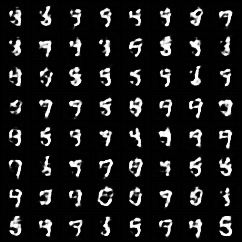

Epoch: 11  | 所要時間 0 分 6 秒
	Loss: -0.5835(Discriminator)
	Loss: -0.3862(Generator)
Epoch: 12  | 所要時間 0 分 6 秒
	Loss: -0.5644(Discriminator)
	Loss: -0.3761(Generator)
Epoch: 13  | 所要時間 0 分 6 秒
	Loss: -0.4871(Discriminator)
	Loss: -0.3170(Generator)
Epoch: 14  | 所要時間 0 分 6 秒
	Loss: -0.4951(Discriminator)
	Loss: -0.3614(Generator)
Epoch: 15  | 所要時間 0 分 6 秒
	Loss: -0.4732(Discriminator)
	Loss: -0.3324(Generator)


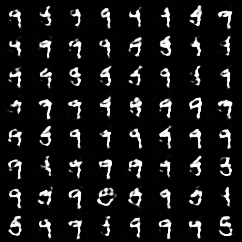

Epoch: 16  | 所要時間 0 分 6 秒
	Loss: -0.4609(Discriminator)
	Loss: -0.3227(Generator)
Epoch: 17  | 所要時間 0 分 6 秒
	Loss: -0.4395(Discriminator)
	Loss: -0.3043(Generator)
Epoch: 18  | 所要時間 0 分 5 秒
	Loss: -0.4300(Discriminator)
	Loss: -0.2921(Generator)
Epoch: 19  | 所要時間 0 分 6 秒
	Loss: -0.4093(Discriminator)
	Loss: -0.2913(Generator)
Epoch: 20  | 所要時間 0 分 6 秒
	Loss: -0.4082(Discriminator)
	Loss: -0.2860(Generator)


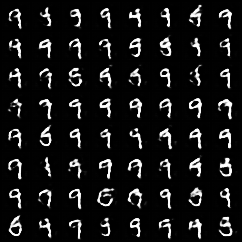

Epoch: 21  | 所要時間 0 分 6 秒
	Loss: -0.3907(Discriminator)
	Loss: -0.2799(Generator)
Epoch: 22  | 所要時間 0 分 6 秒
	Loss: -0.3869(Discriminator)
	Loss: -0.2761(Generator)
Epoch: 23  | 所要時間 0 分 6 秒
	Loss: -0.3732(Discriminator)
	Loss: -0.2836(Generator)
Epoch: 24  | 所要時間 0 分 6 秒
	Loss: -0.3666(Discriminator)
	Loss: -0.2634(Generator)
Epoch: 25  | 所要時間 0 分 6 秒
	Loss: -0.3722(Discriminator)
	Loss: -0.2537(Generator)


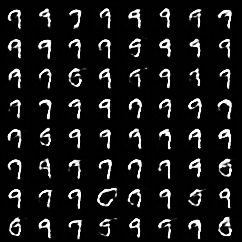

Epoch: 26  | 所要時間 0 分 6 秒
	Loss: -0.3570(Discriminator)
	Loss: -0.2871(Generator)
Epoch: 27  | 所要時間 0 分 6 秒
	Loss: -0.3430(Discriminator)
	Loss: -0.2821(Generator)
Epoch: 28  | 所要時間 0 分 6 秒
	Loss: -0.3385(Discriminator)
	Loss: -0.2645(Generator)
Epoch: 29  | 所要時間 0 分 6 秒
	Loss: -0.3406(Discriminator)
	Loss: -0.2696(Generator)
Epoch: 30  | 所要時間 0 分 6 秒
	Loss: -0.3227(Discriminator)
	Loss: -0.2638(Generator)


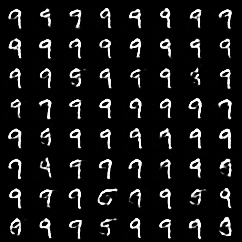

Epoch: 31  | 所要時間 0 分 6 秒
	Loss: -0.3233(Discriminator)
	Loss: -0.2862(Generator)
Epoch: 32  | 所要時間 0 分 6 秒
	Loss: -0.3172(Discriminator)
	Loss: -0.2822(Generator)
Epoch: 33  | 所要時間 0 分 6 秒
	Loss: -0.3182(Discriminator)
	Loss: -0.2572(Generator)
Epoch: 34  | 所要時間 0 分 6 秒
	Loss: -0.3068(Discriminator)
	Loss: -0.2838(Generator)
Epoch: 35  | 所要時間 0 分 6 秒
	Loss: -0.2963(Discriminator)
	Loss: -0.2813(Generator)


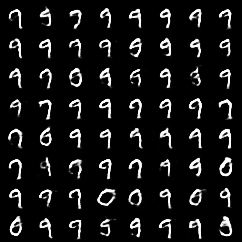

Epoch: 36  | 所要時間 0 分 6 秒
	Loss: -0.2966(Discriminator)
	Loss: -0.2841(Generator)
Epoch: 37  | 所要時間 0 分 6 秒
	Loss: -0.3006(Discriminator)
	Loss: -0.2749(Generator)
Epoch: 38  | 所要時間 0 分 6 秒
	Loss: -0.2952(Discriminator)
	Loss: -0.2917(Generator)
Epoch: 39  | 所要時間 0 分 6 秒
	Loss: -0.2848(Discriminator)
	Loss: -0.2663(Generator)
Epoch: 40  | 所要時間 0 分 6 秒
	Loss: -0.2836(Discriminator)
	Loss: -0.2662(Generator)


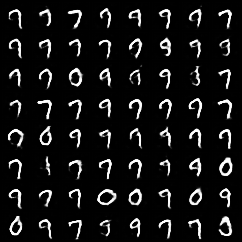

Epoch: 41  | 所要時間 0 分 6 秒
	Loss: -0.2769(Discriminator)
	Loss: -0.2971(Generator)
Epoch: 42  | 所要時間 0 分 6 秒
	Loss: -0.2860(Discriminator)
	Loss: -0.2430(Generator)
Epoch: 43  | 所要時間 0 分 6 秒
	Loss: -0.2760(Discriminator)
	Loss: -0.2850(Generator)
Epoch: 44  | 所要時間 0 分 6 秒
	Loss: -0.2748(Discriminator)
	Loss: -0.3034(Generator)
Epoch: 45  | 所要時間 0 分 6 秒
	Loss: -0.2621(Discriminator)
	Loss: -0.2891(Generator)


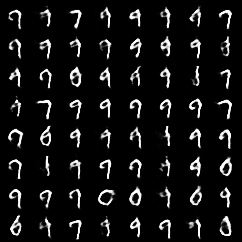

Epoch: 46  | 所要時間 0 分 6 秒
	Loss: -0.2774(Discriminator)
	Loss: -0.3048(Generator)
Epoch: 47  | 所要時間 0 分 6 秒
	Loss: -0.2600(Discriminator)
	Loss: -0.2661(Generator)
Epoch: 48  | 所要時間 0 分 6 秒
	Loss: -0.2561(Discriminator)
	Loss: -0.2917(Generator)
Epoch: 49  | 所要時間 0 分 5 秒
	Loss: -0.2627(Discriminator)
	Loss: -0.2834(Generator)
Epoch: 50  | 所要時間 0 分 6 秒
	Loss: -0.2604(Discriminator)
	Loss: -0.3092(Generator)


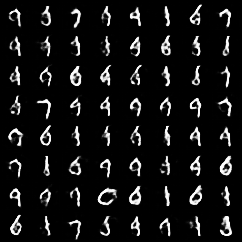

Epoch: 51  | 所要時間 0 分 6 秒
	Loss: -0.2600(Discriminator)
	Loss: -0.2781(Generator)
Epoch: 52  | 所要時間 0 分 6 秒
	Loss: -0.2474(Discriminator)
	Loss: -0.3002(Generator)
Epoch: 53  | 所要時間 0 分 6 秒
	Loss: -0.2568(Discriminator)
	Loss: -0.2668(Generator)
Epoch: 54  | 所要時間 0 分 6 秒
	Loss: -0.2509(Discriminator)
	Loss: -0.3154(Generator)
Epoch: 55  | 所要時間 0 分 6 秒
	Loss: -0.2428(Discriminator)
	Loss: -0.2824(Generator)


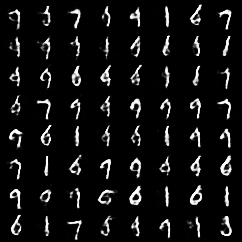

Epoch: 56  | 所要時間 0 分 6 秒
	Loss: -0.2487(Discriminator)
	Loss: -0.2880(Generator)
Epoch: 57  | 所要時間 0 分 6 秒
	Loss: -0.2366(Discriminator)
	Loss: -0.3135(Generator)
Epoch: 58  | 所要時間 0 分 6 秒
	Loss: -0.2427(Discriminator)
	Loss: -0.2796(Generator)
Epoch: 59  | 所要時間 0 分 6 秒
	Loss: -0.2416(Discriminator)
	Loss: -0.3317(Generator)
Epoch: 60  | 所要時間 0 分 6 秒
	Loss: -0.2374(Discriminator)
	Loss: -0.3057(Generator)


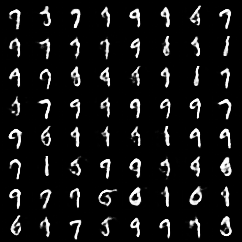

Epoch: 61  | 所要時間 0 分 6 秒
	Loss: -0.2398(Discriminator)
	Loss: -0.2712(Generator)
Epoch: 62  | 所要時間 0 分 6 秒
	Loss: -0.2395(Discriminator)
	Loss: -0.2809(Generator)
Epoch: 63  | 所要時間 0 分 6 秒
	Loss: -0.2331(Discriminator)
	Loss: -0.2726(Generator)
Epoch: 64  | 所要時間 0 分 6 秒
	Loss: -0.2311(Discriminator)
	Loss: -0.2779(Generator)
Epoch: 65  | 所要時間 0 分 6 秒
	Loss: -0.2251(Discriminator)
	Loss: -0.2900(Generator)


Epoch: 66  | 所要時間 0 分 6 秒
	Loss: -0.2271(Discriminator)
	Loss: -0.2870(Generator)
Epoch: 67  | 所要時間 0 分 6 秒
	Loss: -0.2222(Discriminator)
	Loss: -0.2919(Generator)
Epoch: 68  | 所要時間 0 分 6 秒
	Loss: -0.2291(Discriminator)
	Loss: -0.2934(Generator)
Epoch: 69  | 所要時間 0 分 6 秒
	Loss: -0.2198(Discriminator)
	Loss: -0.2721(Generator)
Epoch: 70  | 所要時間 0 分 6 秒
	Loss: -0.2366(Discriminator)
	Loss: -0.3003(Generator)


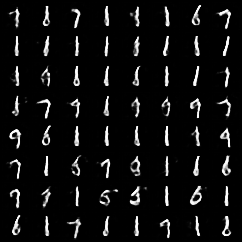

Epoch: 71  | 所要時間 0 分 6 秒
	Loss: -0.2202(Discriminator)
	Loss: -0.3240(Generator)
Epoch: 72  | 所要時間 0 分 6 秒
	Loss: -0.2161(Discriminator)
	Loss: -0.2989(Generator)
Epoch: 73  | 所要時間 0 分 6 秒
	Loss: -0.2199(Discriminator)
	Loss: -0.3052(Generator)
Epoch: 74  | 所要時間 0 分 6 秒
	Loss: -0.2185(Discriminator)
	Loss: -0.3197(Generator)
Epoch: 75  | 所要時間 0 分 6 秒
	Loss: -0.2114(Discriminator)
	Loss: -0.3099(Generator)


Epoch: 76  | 所要時間 0 分 6 秒
	Loss: -0.2168(Discriminator)
	Loss: -0.2748(Generator)
Epoch: 77  | 所要時間 0 分 6 秒
	Loss: -0.2135(Discriminator)
	Loss: -0.3022(Generator)
Epoch: 78  | 所要時間 0 分 6 秒
	Loss: -0.2106(Discriminator)
	Loss: -0.2974(Generator)
Epoch: 79  | 所要時間 0 分 6 秒
	Loss: -0.2150(Discriminator)
	Loss: -0.3158(Generator)
Epoch: 80  | 所要時間 0 分 6 秒
	Loss: -0.2177(Discriminator)
	Loss: -0.3294(Generator)


Epoch: 81  | 所要時間 0 分 6 秒
	Loss: -0.2098(Discriminator)
	Loss: -0.3272(Generator)
Epoch: 82  | 所要時間 0 分 6 秒
	Loss: -0.2129(Discriminator)
	Loss: -0.2970(Generator)
Epoch: 83  | 所要時間 0 分 6 秒
	Loss: -0.1822(Discriminator)
	Loss: -0.2094(Generator)
Epoch: 84  | 所要時間 0 分 6 秒
	Loss: -0.2133(Discriminator)
	Loss: -0.2838(Generator)
Epoch: 85  | 所要時間 0 分 6 秒
	Loss: -0.2049(Discriminator)
	Loss: -0.2271(Generator)


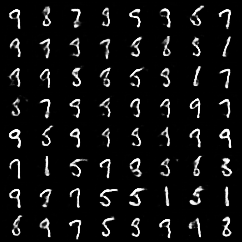

Epoch: 86  | 所要時間 0 分 6 秒
	Loss: -0.2115(Discriminator)
	Loss: -0.2903(Generator)
Epoch: 87  | 所要時間 0 分 5 秒
	Loss: -0.2108(Discriminator)
	Loss: -0.2284(Generator)
Epoch: 88  | 所要時間 0 分 6 秒
	Loss: -0.2045(Discriminator)
	Loss: -0.2619(Generator)
Epoch: 89  | 所要時間 0 分 6 秒
	Loss: -0.2023(Discriminator)
	Loss: -0.2715(Generator)
Epoch: 90  | 所要時間 0 分 5 秒
	Loss: -0.2087(Discriminator)
	Loss: -0.2618(Generator)


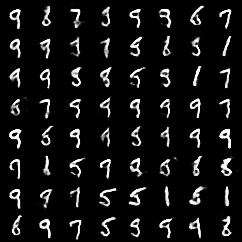

Epoch: 91  | 所要時間 0 分 6 秒
	Loss: -0.2081(Discriminator)
	Loss: -0.2652(Generator)
Epoch: 92  | 所要時間 0 分 6 秒
	Loss: -0.2058(Discriminator)
	Loss: -0.2721(Generator)
Epoch: 93  | 所要時間 0 分 6 秒
	Loss: -0.1970(Discriminator)
	Loss: -0.2873(Generator)
Epoch: 94  | 所要時間 0 分 6 秒
	Loss: -0.1945(Discriminator)
	Loss: -0.2862(Generator)
Epoch: 95  | 所要時間 0 分 6 秒
	Loss: -0.2035(Discriminator)
	Loss: -0.2960(Generator)


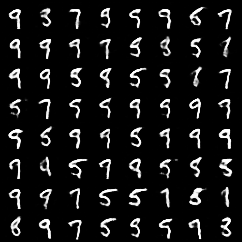

Epoch: 96  | 所要時間 0 分 6 秒
	Loss: -0.2058(Discriminator)
	Loss: -0.2739(Generator)
Epoch: 97  | 所要時間 0 分 6 秒
	Loss: -0.1960(Discriminator)
	Loss: -0.2883(Generator)
Epoch: 98  | 所要時間 0 分 6 秒
	Loss: -0.2066(Discriminator)
	Loss: -0.2871(Generator)
Epoch: 99  | 所要時間 0 分 6 秒
	Loss: -0.2024(Discriminator)
	Loss: -0.2880(Generator)
Epoch: 100  | 所要時間 0 分 6 秒
	Loss: -0.1957(Discriminator)
	Loss: -0.2419(Generator)


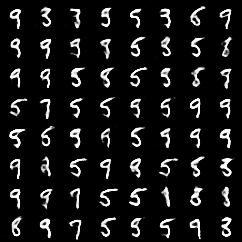

Epoch: 101  | 所要時間 0 分 6 秒
	Loss: -0.1796(Discriminator)
	Loss: -0.2944(Generator)
Epoch: 102  | 所要時間 0 分 6 秒
	Loss: -0.1960(Discriminator)
	Loss: -0.2830(Generator)
Epoch: 103  | 所要時間 0 分 5 秒
	Loss: -0.1977(Discriminator)
	Loss: -0.2867(Generator)
Epoch: 104  | 所要時間 0 分 6 秒
	Loss: -0.1956(Discriminator)
	Loss: -0.2947(Generator)
Epoch: 105  | 所要時間 0 分 6 秒
	Loss: -0.1951(Discriminator)
	Loss: -0.2557(Generator)


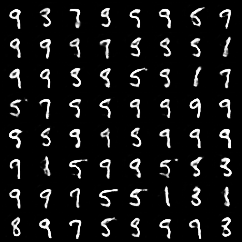

Epoch: 106  | 所要時間 0 分 6 秒
	Loss: -0.1956(Discriminator)
	Loss: -0.2714(Generator)
Epoch: 107  | 所要時間 0 分 6 秒
	Loss: -0.1871(Discriminator)
	Loss: -0.2927(Generator)
Epoch: 108  | 所要時間 0 分 6 秒
	Loss: -0.1878(Discriminator)
	Loss: -0.2155(Generator)
Epoch: 109  | 所要時間 0 分 6 秒
	Loss: -0.1890(Discriminator)
	Loss: -0.3375(Generator)
Epoch: 110  | 所要時間 0 分 6 秒
	Loss: -0.1838(Discriminator)
	Loss: -0.2831(Generator)


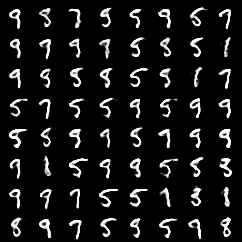

Epoch: 111  | 所要時間 0 分 6 秒
	Loss: -0.1955(Discriminator)
	Loss: -0.3020(Generator)
Epoch: 112  | 所要時間 0 分 6 秒
	Loss: -0.1912(Discriminator)
	Loss: -0.2503(Generator)
Epoch: 113  | 所要時間 0 分 6 秒
	Loss: -0.1842(Discriminator)
	Loss: -0.2823(Generator)
Epoch: 114  | 所要時間 0 分 6 秒
	Loss: -0.1904(Discriminator)
	Loss: -0.2398(Generator)
Epoch: 115  | 所要時間 0 分 6 秒
	Loss: -0.1822(Discriminator)
	Loss: -0.2900(Generator)


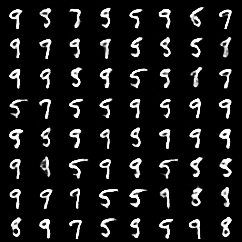

Epoch: 116  | 所要時間 0 分 6 秒
	Loss: -0.1796(Discriminator)
	Loss: -0.1487(Generator)
Epoch: 117  | 所要時間 0 分 6 秒
	Loss: -0.1857(Discriminator)
	Loss: -0.2674(Generator)
Epoch: 118  | 所要時間 0 分 6 秒
	Loss: -0.1874(Discriminator)
	Loss: -0.2459(Generator)
Epoch: 119  | 所要時間 0 分 6 秒
	Loss: -0.1847(Discriminator)
	Loss: -0.2586(Generator)
Epoch: 120  | 所要時間 0 分 6 秒
	Loss: -0.1826(Discriminator)
	Loss: -0.2498(Generator)


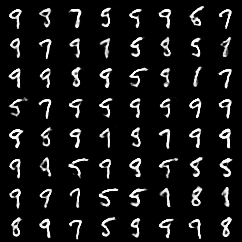

Epoch: 121  | 所要時間 0 分 6 秒
	Loss: -0.2072(Discriminator)
	Loss: -0.2272(Generator)
Epoch: 122  | 所要時間 0 分 6 秒
	Loss: -0.1779(Discriminator)
	Loss: -0.2482(Generator)
Epoch: 123  | 所要時間 0 分 6 秒
	Loss: -0.1654(Discriminator)
	Loss: -0.2525(Generator)
Epoch: 124  | 所要時間 0 分 6 秒
	Loss: -0.1822(Discriminator)
	Loss: -0.2661(Generator)
Epoch: 125  | 所要時間 0 分 6 秒
	Loss: -0.1851(Discriminator)
	Loss: -0.2291(Generator)


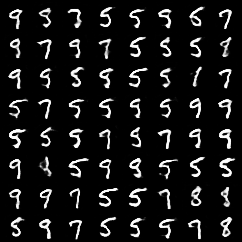

Epoch: 126  | 所要時間 0 分 6 秒
	Loss: -0.1751(Discriminator)
	Loss: -0.2387(Generator)
Epoch: 127  | 所要時間 0 分 6 秒
	Loss: -0.1682(Discriminator)
	Loss: -0.3339(Generator)
Epoch: 128  | 所要時間 0 分 6 秒
	Loss: -0.1922(Discriminator)
	Loss: -0.2058(Generator)
Epoch: 129  | 所要時間 0 分 6 秒
	Loss: -0.1818(Discriminator)
	Loss: -0.2631(Generator)
Epoch: 130  | 所要時間 0 分 6 秒
	Loss: -0.1842(Discriminator)
	Loss: -0.3105(Generator)


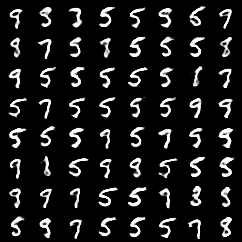

Epoch: 131  | 所要時間 0 分 6 秒
	Loss: -0.1854(Discriminator)
	Loss: -0.2342(Generator)
Epoch: 132  | 所要時間 0 分 6 秒
	Loss: -0.1702(Discriminator)
	Loss: -0.2332(Generator)
Epoch: 133  | 所要時間 0 分 6 秒
	Loss: -0.1846(Discriminator)
	Loss: -0.2470(Generator)
Epoch: 134  | 所要時間 0 分 6 秒
	Loss: -0.1836(Discriminator)
	Loss: -0.2529(Generator)
Epoch: 135  | 所要時間 0 分 6 秒
	Loss: -0.1764(Discriminator)
	Loss: -0.1744(Generator)


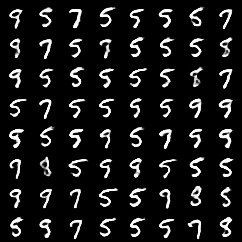

Epoch: 136  | 所要時間 0 分 6 秒
	Loss: -0.1815(Discriminator)
	Loss: -0.2590(Generator)
Epoch: 137  | 所要時間 0 分 6 秒
	Loss: -0.1722(Discriminator)
	Loss: -0.2403(Generator)
Epoch: 138  | 所要時間 0 分 6 秒
	Loss: -0.1781(Discriminator)
	Loss: -0.2152(Generator)
Epoch: 139  | 所要時間 0 分 6 秒
	Loss: -0.1771(Discriminator)
	Loss: -0.2854(Generator)
Epoch: 140  | 所要時間 0 分 6 秒
	Loss: -0.1770(Discriminator)
	Loss: -0.2492(Generator)


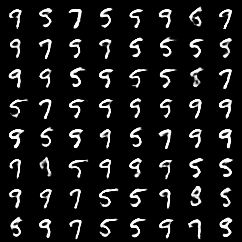

Epoch: 141  | 所要時間 0 分 6 秒
	Loss: -0.1688(Discriminator)
	Loss: -0.2131(Generator)
Epoch: 142  | 所要時間 0 分 6 秒
	Loss: -0.1790(Discriminator)
	Loss: -0.2510(Generator)
Epoch: 143  | 所要時間 0 分 6 秒
	Loss: -0.1831(Discriminator)
	Loss: -0.2743(Generator)
Epoch: 144  | 所要時間 0 分 6 秒
	Loss: -0.1699(Discriminator)
	Loss: -0.2475(Generator)
Epoch: 145  | 所要時間 0 分 6 秒
	Loss: -0.1727(Discriminator)
	Loss: -0.2246(Generator)


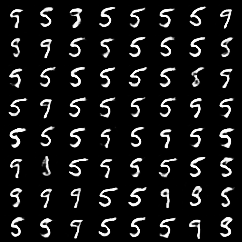

Epoch: 146  | 所要時間 0 分 6 秒
	Loss: -0.1827(Discriminator)
	Loss: -0.3051(Generator)
Epoch: 147  | 所要時間 0 分 6 秒
	Loss: -0.1782(Discriminator)
	Loss: -0.2764(Generator)
Epoch: 148  | 所要時間 0 分 6 秒
	Loss: -0.0590(Discriminator)
	Loss: -0.3218(Generator)
Epoch: 149  | 所要時間 0 分 6 秒
	Loss: -0.1607(Discriminator)
	Loss: -0.2789(Generator)
Epoch: 150  | 所要時間 0 分 6 秒
	Loss: -0.1772(Discriminator)
	Loss: -0.1940(Generator)


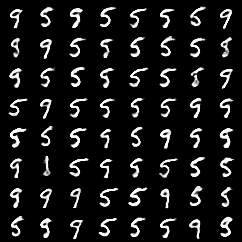

Epoch: 151  | 所要時間 0 分 6 秒
	Loss: -0.1786(Discriminator)
	Loss: -0.2168(Generator)
Epoch: 152  | 所要時間 0 分 6 秒
	Loss: -0.1768(Discriminator)
	Loss: -0.2627(Generator)
Epoch: 153  | 所要時間 0 分 6 秒
	Loss: -0.1748(Discriminator)
	Loss: -0.2296(Generator)
Epoch: 154  | 所要時間 0 分 6 秒
	Loss: -0.1774(Discriminator)
	Loss: -0.2768(Generator)
Epoch: 155  | 所要時間 0 分 6 秒
	Loss: -0.1754(Discriminator)
	Loss: -0.2655(Generator)


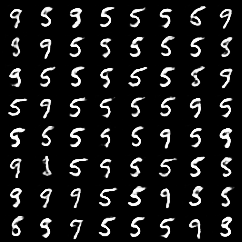

Epoch: 156  | 所要時間 0 分 6 秒
	Loss: -0.1773(Discriminator)
	Loss: -0.2931(Generator)
Epoch: 157  | 所要時間 0 分 6 秒
	Loss: -0.1760(Discriminator)
	Loss: -0.1516(Generator)
Epoch: 158  | 所要時間 0 分 6 秒
	Loss: -0.1680(Discriminator)
	Loss: -0.2853(Generator)
Epoch: 159  | 所要時間 0 分 6 秒
	Loss: -0.1730(Discriminator)
	Loss: -0.2097(Generator)
Epoch: 160  | 所要時間 0 分 6 秒
	Loss: -0.1736(Discriminator)
	Loss: -0.2294(Generator)


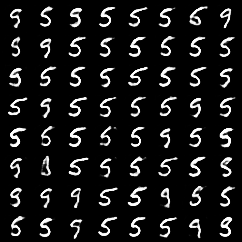

Epoch: 161  | 所要時間 0 分 6 秒
	Loss: -0.1675(Discriminator)
	Loss: -0.2192(Generator)
Epoch: 162  | 所要時間 0 分 6 秒
	Loss: -0.1706(Discriminator)
	Loss: -0.2817(Generator)
Epoch: 163  | 所要時間 0 分 6 秒
	Loss: -0.1713(Discriminator)
	Loss: -0.2981(Generator)
Epoch: 164  | 所要時間 0 分 6 秒
	Loss: -0.1791(Discriminator)
	Loss: -0.2436(Generator)
Epoch: 165  | 所要時間 0 分 6 秒
	Loss: -0.1747(Discriminator)
	Loss: -0.2837(Generator)


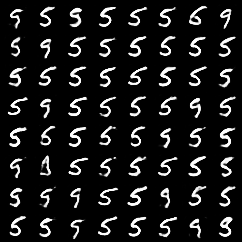

Epoch: 166  | 所要時間 0 分 6 秒
	Loss: -0.1697(Discriminator)
	Loss: -0.2090(Generator)
Epoch: 167  | 所要時間 0 分 6 秒
	Loss: -0.1665(Discriminator)
	Loss: -0.2512(Generator)
Epoch: 168  | 所要時間 0 分 6 秒
	Loss: -0.1753(Discriminator)
	Loss: -0.2806(Generator)
Epoch: 169  | 所要時間 0 分 6 秒
	Loss: -0.1645(Discriminator)
	Loss: -0.2778(Generator)
Epoch: 170  | 所要時間 0 分 6 秒
	Loss: -0.1707(Discriminator)
	Loss: -0.1895(Generator)


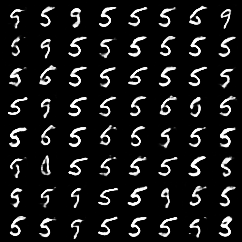

Epoch: 171  | 所要時間 0 分 6 秒
	Loss: -0.1657(Discriminator)
	Loss: -0.2777(Generator)
Epoch: 172  | 所要時間 0 分 6 秒
	Loss: -0.1598(Discriminator)
	Loss: -0.3034(Generator)
Epoch: 173  | 所要時間 0 分 6 秒
	Loss: -0.1636(Discriminator)
	Loss: -0.2211(Generator)
Epoch: 174  | 所要時間 0 分 6 秒
	Loss: -0.1641(Discriminator)
	Loss: -0.2707(Generator)
Epoch: 175  | 所要時間 0 分 6 秒
	Loss: -0.1631(Discriminator)
	Loss: -0.3840(Generator)


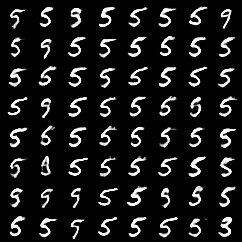

Epoch: 176  | 所要時間 0 分 6 秒
	Loss: -0.1602(Discriminator)
	Loss: -0.2730(Generator)
Epoch: 177  | 所要時間 0 分 6 秒
	Loss: -0.1585(Discriminator)
	Loss: -0.1925(Generator)
Epoch: 178  | 所要時間 0 分 5 秒
	Loss: -0.1671(Discriminator)
	Loss: -0.3522(Generator)
Epoch: 179  | 所要時間 0 分 6 秒
	Loss: -0.1637(Discriminator)
	Loss: -0.2119(Generator)
Epoch: 180  | 所要時間 0 分 6 秒
	Loss: -0.1593(Discriminator)
	Loss: -0.3059(Generator)


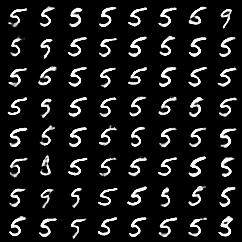

Epoch: 181  | 所要時間 0 分 6 秒
	Loss: -0.1617(Discriminator)
	Loss: -0.2463(Generator)
Epoch: 182  | 所要時間 0 分 6 秒
	Loss: -0.1629(Discriminator)
	Loss: -0.2928(Generator)
Epoch: 183  | 所要時間 0 分 6 秒
	Loss: -0.1678(Discriminator)
	Loss: -0.2570(Generator)
Epoch: 184  | 所要時間 0 分 6 秒
	Loss: -0.1602(Discriminator)
	Loss: -0.2921(Generator)
Epoch: 185  | 所要時間 0 分 6 秒
	Loss: -0.1552(Discriminator)
	Loss: -0.3009(Generator)


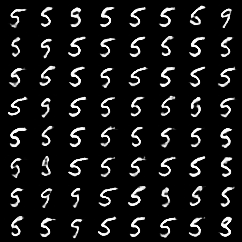

Epoch: 186  | 所要時間 0 分 6 秒
	Loss: -0.1589(Discriminator)
	Loss: -0.3230(Generator)
Epoch: 187  | 所要時間 0 分 6 秒
	Loss: -0.1741(Discriminator)
	Loss: -0.3082(Generator)
Epoch: 188  | 所要時間 0 分 6 秒
	Loss: -0.1621(Discriminator)
	Loss: -0.1788(Generator)
Epoch: 189  | 所要時間 0 分 5 秒
	Loss: -0.1649(Discriminator)
	Loss: -0.2748(Generator)
Epoch: 190  | 所要時間 0 分 6 秒
	Loss: -0.1051(Discriminator)
	Loss: -0.2641(Generator)


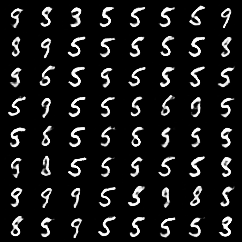

Epoch: 191  | 所要時間 0 分 6 秒
	Loss: -0.1557(Discriminator)
	Loss: -0.1645(Generator)
Epoch: 192  | 所要時間 0 分 6 秒
	Loss: -0.1533(Discriminator)
	Loss: -0.2628(Generator)
Epoch: 193  | 所要時間 0 分 6 秒
	Loss: -0.1561(Discriminator)
	Loss: -0.2509(Generator)
Epoch: 194  | 所要時間 0 分 6 秒
	Loss: -0.1635(Discriminator)
	Loss: -0.3252(Generator)
Epoch: 195  | 所要時間 0 分 6 秒
	Loss: -0.1618(Discriminator)
	Loss: -0.2596(Generator)


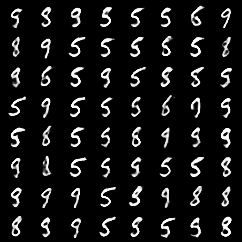

Epoch: 196  | 所要時間 0 分 6 秒
	Loss: -0.1587(Discriminator)
	Loss: -0.2937(Generator)
Epoch: 197  | 所要時間 0 分 6 秒
	Loss: -0.1601(Discriminator)
	Loss: -0.2833(Generator)
Epoch: 198  | 所要時間 0 分 6 秒
	Loss: -0.1629(Discriminator)
	Loss: -0.3146(Generator)
Epoch: 199  | 所要時間 0 分 6 秒
	Loss: -0.1605(Discriminator)
	Loss: -0.2724(Generator)
Epoch: 200  | 所要時間 0 分 6 秒
	Loss: -0.1592(Discriminator)
	Loss: -0.2965(Generator)


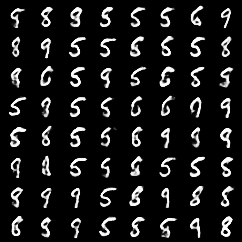

Epoch: 201  | 所要時間 0 分 6 秒
	Loss: -0.1686(Discriminator)
	Loss: -0.2466(Generator)
Epoch: 202  | 所要時間 0 分 6 秒
	Loss: -0.1695(Discriminator)
	Loss: -0.3796(Generator)
Epoch: 203  | 所要時間 0 分 6 秒
	Loss: -0.1605(Discriminator)
	Loss: -0.2873(Generator)
Epoch: 204  | 所要時間 0 分 6 秒
	Loss: -0.1502(Discriminator)
	Loss: -0.2968(Generator)
Epoch: 205  | 所要時間 0 分 6 秒
	Loss: -0.1606(Discriminator)
	Loss: -0.2210(Generator)


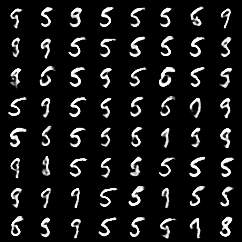

Epoch: 206  | 所要時間 0 分 6 秒
	Loss: -0.1578(Discriminator)
	Loss: -0.3347(Generator)
Epoch: 207  | 所要時間 0 分 6 秒
	Loss: -0.1576(Discriminator)
	Loss: -0.3346(Generator)
Epoch: 208  | 所要時間 0 分 6 秒
	Loss: -0.1572(Discriminator)
	Loss: -0.2660(Generator)
Epoch: 209  | 所要時間 0 分 6 秒
	Loss: -0.1602(Discriminator)
	Loss: -0.3584(Generator)
Epoch: 210  | 所要時間 0 分 6 秒
	Loss: -0.1562(Discriminator)
	Loss: -0.2654(Generator)


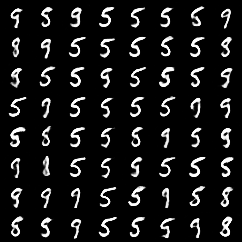

Epoch: 211  | 所要時間 0 分 6 秒
	Loss: -0.1514(Discriminator)
	Loss: -0.3008(Generator)
Epoch: 212  | 所要時間 0 分 6 秒
	Loss: -0.1732(Discriminator)
	Loss: -0.3756(Generator)
Epoch: 213  | 所要時間 0 分 6 秒
	Loss: -0.1509(Discriminator)
	Loss: -0.2967(Generator)
Epoch: 214  | 所要時間 0 分 6 秒
	Loss: -0.1606(Discriminator)
	Loss: -0.2714(Generator)
Epoch: 215  | 所要時間 0 分 6 秒
	Loss: -0.1673(Discriminator)
	Loss: -0.2840(Generator)


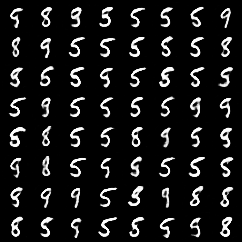

Epoch: 216  | 所要時間 0 分 6 秒
	Loss: -0.1552(Discriminator)
	Loss: -0.3450(Generator)
Epoch: 217  | 所要時間 0 分 6 秒
	Loss: -0.1477(Discriminator)
	Loss: -0.2006(Generator)
Epoch: 218  | 所要時間 0 分 6 秒
	Loss: -0.1643(Discriminator)
	Loss: -0.3063(Generator)
Epoch: 219  | 所要時間 0 分 6 秒
	Loss: -0.1500(Discriminator)
	Loss: -0.3342(Generator)
Epoch: 220  | 所要時間 0 分 6 秒
	Loss: -0.1552(Discriminator)
	Loss: -0.2702(Generator)


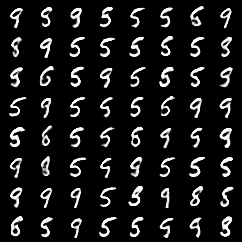

Epoch: 221  | 所要時間 0 分 6 秒
	Loss: -0.1530(Discriminator)
	Loss: -0.3528(Generator)
Epoch: 222  | 所要時間 0 分 6 秒
	Loss: -0.1578(Discriminator)
	Loss: -0.3639(Generator)
Epoch: 223  | 所要時間 0 分 6 秒
	Loss: -0.1534(Discriminator)
	Loss: -0.2982(Generator)
Epoch: 224  | 所要時間 0 分 6 秒
	Loss: -0.1517(Discriminator)
	Loss: -0.3101(Generator)
Epoch: 225  | 所要時間 0 分 6 秒
	Loss: -0.1509(Discriminator)
	Loss: -0.3221(Generator)


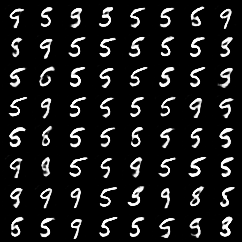

Epoch: 226  | 所要時間 0 分 6 秒
	Loss: -0.1606(Discriminator)
	Loss: -0.2345(Generator)
Epoch: 227  | 所要時間 0 分 6 秒
	Loss: -0.1468(Discriminator)
	Loss: -0.3825(Generator)
Epoch: 228  | 所要時間 0 分 6 秒
	Loss: -0.1493(Discriminator)
	Loss: -0.3786(Generator)
Epoch: 229  | 所要時間 0 分 6 秒
	Loss: -0.1074(Discriminator)
	Loss: -0.2393(Generator)
Epoch: 230  | 所要時間 0 分 6 秒
	Loss: -0.1507(Discriminator)
	Loss: -0.2668(Generator)


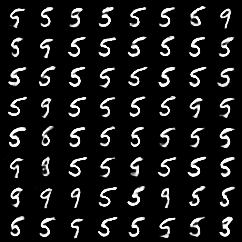

Epoch: 231  | 所要時間 0 分 6 秒
	Loss: -0.1448(Discriminator)
	Loss: -0.3313(Generator)
Epoch: 232  | 所要時間 0 分 6 秒
	Loss: -0.1490(Discriminator)
	Loss: -0.2982(Generator)
Epoch: 233  | 所要時間 0 分 6 秒
	Loss: -0.1629(Discriminator)
	Loss: -0.3154(Generator)
Epoch: 234  | 所要時間 0 分 6 秒
	Loss: -0.1551(Discriminator)
	Loss: -0.2575(Generator)
Epoch: 235  | 所要時間 0 分 6 秒
	Loss: -0.1552(Discriminator)
	Loss: -0.3017(Generator)


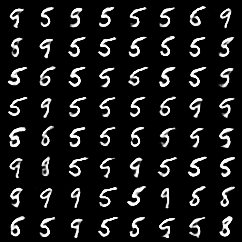

Epoch: 236  | 所要時間 0 分 6 秒
	Loss: -0.1425(Discriminator)
	Loss: -0.3224(Generator)
Epoch: 237  | 所要時間 0 分 6 秒
	Loss: -0.1468(Discriminator)
	Loss: -0.3296(Generator)
Epoch: 238  | 所要時間 0 分 6 秒
	Loss: -0.1401(Discriminator)
	Loss: -0.3204(Generator)
Epoch: 239  | 所要時間 0 分 6 秒
	Loss: -0.1487(Discriminator)
	Loss: -0.3946(Generator)
Epoch: 240  | 所要時間 0 分 6 秒
	Loss: -0.1491(Discriminator)
	Loss: -0.3439(Generator)


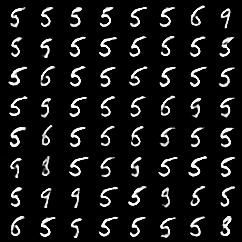

Epoch: 241  | 所要時間 0 分 6 秒
	Loss: -0.1509(Discriminator)
	Loss: -0.3881(Generator)
Epoch: 242  | 所要時間 0 分 6 秒
	Loss: -0.1416(Discriminator)
	Loss: -0.2574(Generator)
Epoch: 243  | 所要時間 0 分 6 秒
	Loss: -0.1539(Discriminator)
	Loss: -0.3321(Generator)
Epoch: 244  | 所要時間 0 分 6 秒
	Loss: -0.1546(Discriminator)
	Loss: -0.3851(Generator)
Epoch: 245  | 所要時間 0 分 6 秒
	Loss: -0.1489(Discriminator)
	Loss: -0.3146(Generator)


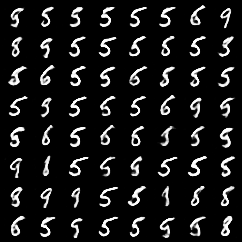

Epoch: 246  | 所要時間 0 分 6 秒
	Loss: -0.1488(Discriminator)
	Loss: -0.2954(Generator)
Epoch: 247  | 所要時間 0 分 6 秒
	Loss: -0.1521(Discriminator)
	Loss: -0.2961(Generator)
Epoch: 248  | 所要時間 0 分 6 秒
	Loss: -0.1511(Discriminator)
	Loss: -0.2975(Generator)
Epoch: 249  | 所要時間 0 分 6 秒
	Loss: -0.1519(Discriminator)
	Loss: -0.3564(Generator)
Epoch: 250  | 所要時間 0 分 6 秒
	Loss: -0.1511(Discriminator)
	Loss: -0.3432(Generator)


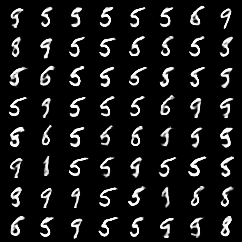

Epoch: 251  | 所要時間 0 分 5 秒
	Loss: -0.1527(Discriminator)
	Loss: -0.3053(Generator)
Epoch: 252  | 所要時間 0 分 6 秒
	Loss: -0.1508(Discriminator)
	Loss: -0.3933(Generator)
Epoch: 253  | 所要時間 0 分 6 秒
	Loss: -0.1581(Discriminator)
	Loss: -0.2965(Generator)
Epoch: 254  | 所要時間 0 分 6 秒
	Loss: -0.1484(Discriminator)
	Loss: -0.3556(Generator)
Epoch: 255  | 所要時間 0 分 6 秒
	Loss: -0.1321(Discriminator)
	Loss: -0.3422(Generator)


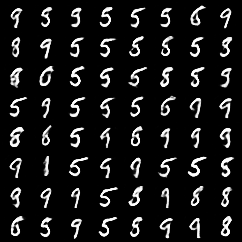

Epoch: 256  | 所要時間 0 分 6 秒
	Loss: -0.1625(Discriminator)
	Loss: -0.3378(Generator)
Epoch: 257  | 所要時間 0 分 6 秒
	Loss: -0.1496(Discriminator)
	Loss: -0.3158(Generator)
Epoch: 258  | 所要時間 0 分 6 秒
	Loss: -0.1419(Discriminator)
	Loss: -0.3833(Generator)
Epoch: 259  | 所要時間 0 分 6 秒
	Loss: -0.1462(Discriminator)
	Loss: -0.3616(Generator)
Epoch: 260  | 所要時間 0 分 6 秒
	Loss: -0.1458(Discriminator)
	Loss: -0.3161(Generator)


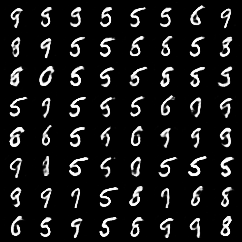

Epoch: 261  | 所要時間 0 分 6 秒
	Loss: -0.1542(Discriminator)
	Loss: -0.3811(Generator)
Epoch: 262  | 所要時間 0 分 6 秒
	Loss: -0.1500(Discriminator)
	Loss: -0.2908(Generator)
Epoch: 263  | 所要時間 0 分 6 秒
	Loss: -0.1473(Discriminator)
	Loss: -0.3259(Generator)
Epoch: 264  | 所要時間 0 分 6 秒
	Loss: -0.1542(Discriminator)
	Loss: -0.3500(Generator)
Epoch: 265  | 所要時間 0 分 6 秒
	Loss: -0.1496(Discriminator)
	Loss: -0.3120(Generator)


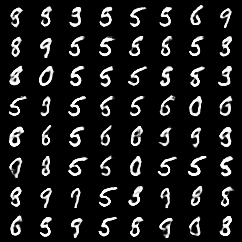

Epoch: 266  | 所要時間 0 分 6 秒
	Loss: -0.1462(Discriminator)
	Loss: -0.2696(Generator)
Epoch: 267  | 所要時間 0 分 6 秒
	Loss: -0.1471(Discriminator)
	Loss: -0.4089(Generator)
Epoch: 268  | 所要時間 0 分 6 秒
	Loss: -0.1453(Discriminator)
	Loss: -0.4130(Generator)
Epoch: 269  | 所要時間 0 分 6 秒
	Loss: -0.1479(Discriminator)
	Loss: -0.3902(Generator)
Epoch: 270  | 所要時間 0 分 6 秒
	Loss: -0.1567(Discriminator)
	Loss: -0.3717(Generator)


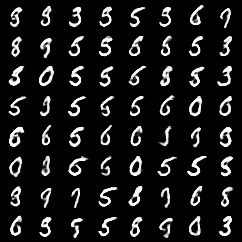

Epoch: 271  | 所要時間 0 分 6 秒
	Loss: -0.1490(Discriminator)
	Loss: -0.3465(Generator)
Epoch: 272  | 所要時間 0 分 6 秒
	Loss: -0.1425(Discriminator)
	Loss: -0.4372(Generator)
Epoch: 273  | 所要時間 0 分 6 秒
	Loss: -0.1560(Discriminator)
	Loss: -0.3545(Generator)
Epoch: 274  | 所要時間 0 分 6 秒
	Loss: -0.1426(Discriminator)
	Loss: -0.3162(Generator)
Epoch: 275  | 所要時間 0 分 6 秒
	Loss: -0.1491(Discriminator)
	Loss: -0.4063(Generator)


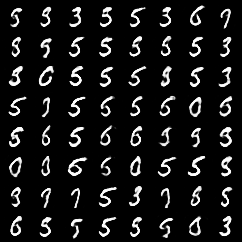

Epoch: 276  | 所要時間 0 分 6 秒
	Loss: -0.1460(Discriminator)
	Loss: -0.4426(Generator)
Epoch: 277  | 所要時間 0 分 6 秒
	Loss: -0.1352(Discriminator)
	Loss: -0.3646(Generator)
Epoch: 278  | 所要時間 0 分 6 秒
	Loss: -0.1346(Discriminator)
	Loss: -0.4118(Generator)
Epoch: 279  | 所要時間 0 分 6 秒
	Loss: -0.1397(Discriminator)
	Loss: -0.3604(Generator)
Epoch: 280  | 所要時間 0 分 6 秒
	Loss: -0.1542(Discriminator)
	Loss: -0.4498(Generator)


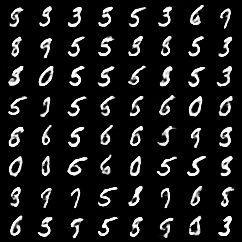

Epoch: 281  | 所要時間 0 分 6 秒
	Loss: -0.1483(Discriminator)
	Loss: -0.3031(Generator)
Epoch: 282  | 所要時間 0 分 6 秒
	Loss: -0.1463(Discriminator)
	Loss: -0.4497(Generator)
Epoch: 283  | 所要時間 0 分 6 秒
	Loss: -0.1394(Discriminator)
	Loss: -0.3952(Generator)
Epoch: 284  | 所要時間 0 分 6 秒
	Loss: -0.1426(Discriminator)
	Loss: -0.4424(Generator)
Epoch: 285  | 所要時間 0 分 6 秒
	Loss: -0.1454(Discriminator)
	Loss: -0.3975(Generator)


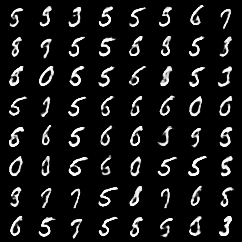

Epoch: 286  | 所要時間 0 分 6 秒
	Loss: -0.0768(Discriminator)
	Loss: -0.3883(Generator)
Epoch: 287  | 所要時間 0 分 6 秒
	Loss: -0.1373(Discriminator)
	Loss: -0.2090(Generator)
Epoch: 288  | 所要時間 0 分 6 秒
	Loss: -0.1388(Discriminator)
	Loss: -0.2479(Generator)
Epoch: 289  | 所要時間 0 分 5 秒
	Loss: -0.1557(Discriminator)
	Loss: -0.4109(Generator)
Epoch: 290  | 所要時間 0 分 6 秒
	Loss: -0.1341(Discriminator)
	Loss: -0.4100(Generator)


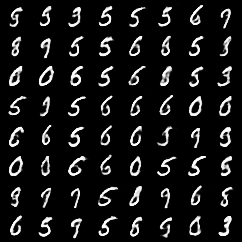

Epoch: 291  | 所要時間 0 分 5 秒
	Loss: -0.1402(Discriminator)
	Loss: -0.4037(Generator)
Epoch: 292  | 所要時間 0 分 6 秒
	Loss: -0.1445(Discriminator)
	Loss: -0.4200(Generator)
Epoch: 293  | 所要時間 0 分 6 秒
	Loss: -0.1466(Discriminator)
	Loss: -0.4031(Generator)
Epoch: 294  | 所要時間 0 分 6 秒
	Loss: -0.1410(Discriminator)
	Loss: -0.3534(Generator)
Epoch: 295  | 所要時間 0 分 6 秒
	Loss: -0.1302(Discriminator)
	Loss: -0.4692(Generator)


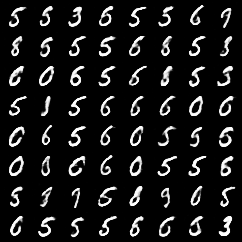

Epoch: 296  | 所要時間 0 分 5 秒
	Loss: -0.1466(Discriminator)
	Loss: -0.4929(Generator)
Epoch: 297  | 所要時間 0 分 6 秒
	Loss: -0.1434(Discriminator)
	Loss: -0.2942(Generator)
Epoch: 298  | 所要時間 0 分 6 秒
	Loss: -0.1472(Discriminator)
	Loss: -0.4199(Generator)
Epoch: 299  | 所要時間 0 分 6 秒
	Loss: -0.1457(Discriminator)
	Loss: -0.4013(Generator)
Epoch: 300  | 所要時間 0 分 6 秒
	Loss: -0.1357(Discriminator)
	Loss: -0.3487(Generator)


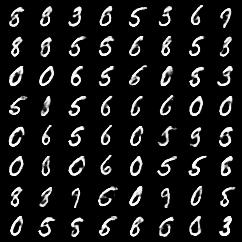

Epoch: 301  | 所要時間 0 分 6 秒
	Loss: -0.1436(Discriminator)
	Loss: -0.5387(Generator)
Epoch: 302  | 所要時間 0 分 6 秒
	Loss: -0.1373(Discriminator)
	Loss: -0.3977(Generator)
Epoch: 303  | 所要時間 0 分 6 秒
	Loss: -0.1366(Discriminator)
	Loss: -0.4009(Generator)
Epoch: 304  | 所要時間 0 分 6 秒
	Loss: -0.1519(Discriminator)
	Loss: -0.4321(Generator)
Epoch: 305  | 所要時間 0 分 6 秒
	Loss: -0.1393(Discriminator)
	Loss: -0.3815(Generator)


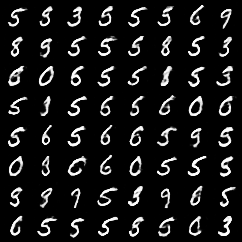

Epoch: 306  | 所要時間 0 分 6 秒
	Loss: -0.1416(Discriminator)
	Loss: -0.4955(Generator)
Epoch: 307  | 所要時間 0 分 6 秒
	Loss: -0.1550(Discriminator)
	Loss: -0.4068(Generator)
Epoch: 308  | 所要時間 0 分 6 秒
	Loss: -0.1460(Discriminator)
	Loss: -0.4632(Generator)
Epoch: 309  | 所要時間 0 分 6 秒
	Loss: -0.1379(Discriminator)
	Loss: -0.5144(Generator)
Epoch: 310  | 所要時間 0 分 6 秒
	Loss: -0.1322(Discriminator)
	Loss: -0.3593(Generator)


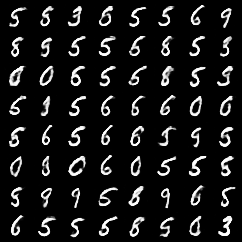

Epoch: 311  | 所要時間 0 分 6 秒
	Loss: -0.1348(Discriminator)
	Loss: -0.4871(Generator)
Epoch: 312  | 所要時間 0 分 6 秒
	Loss: -0.1405(Discriminator)
	Loss: -0.4305(Generator)
Epoch: 313  | 所要時間 0 分 6 秒
	Loss: -0.1409(Discriminator)
	Loss: -0.4664(Generator)
Epoch: 314  | 所要時間 0 分 6 秒
	Loss: -0.1460(Discriminator)
	Loss: -0.3784(Generator)
Epoch: 315  | 所要時間 0 分 6 秒
	Loss: -0.1415(Discriminator)
	Loss: -0.4500(Generator)


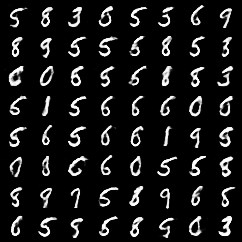

Epoch: 316  | 所要時間 0 分 6 秒
	Loss: -0.1383(Discriminator)
	Loss: -0.4573(Generator)
Epoch: 317  | 所要時間 0 分 6 秒
	Loss: -0.1521(Discriminator)
	Loss: -0.4869(Generator)
Epoch: 318  | 所要時間 0 分 6 秒
	Loss: -0.1450(Discriminator)
	Loss: -0.4270(Generator)
Epoch: 319  | 所要時間 0 分 6 秒
	Loss: -0.1424(Discriminator)
	Loss: -0.4076(Generator)
Epoch: 320  | 所要時間 0 分 6 秒
	Loss: -0.1398(Discriminator)
	Loss: -0.4138(Generator)


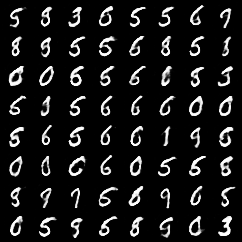

Epoch: 321  | 所要時間 0 分 6 秒
	Loss: -0.1379(Discriminator)
	Loss: -0.4013(Generator)
Epoch: 322  | 所要時間 0 分 6 秒
	Loss: -0.1414(Discriminator)
	Loss: -0.4589(Generator)
Epoch: 323  | 所要時間 0 分 6 秒
	Loss: -0.1399(Discriminator)
	Loss: -0.3294(Generator)
Epoch: 324  | 所要時間 0 分 6 秒
	Loss: -0.1453(Discriminator)
	Loss: -0.4020(Generator)
Epoch: 325  | 所要時間 0 分 6 秒
	Loss: -0.1431(Discriminator)
	Loss: -0.4480(Generator)


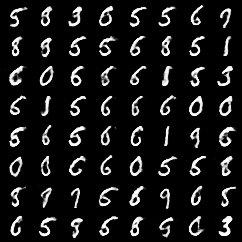

Epoch: 326  | 所要時間 0 分 6 秒
	Loss: -0.1376(Discriminator)
	Loss: -0.4338(Generator)
Epoch: 327  | 所要時間 0 分 6 秒
	Loss: -0.1424(Discriminator)
	Loss: -0.5395(Generator)
Epoch: 328  | 所要時間 0 分 6 秒
	Loss: -0.1396(Discriminator)
	Loss: -0.3375(Generator)
Epoch: 329  | 所要時間 0 分 6 秒
	Loss: -0.1443(Discriminator)
	Loss: -0.5370(Generator)
Epoch: 330  | 所要時間 0 分 6 秒
	Loss: -0.1427(Discriminator)
	Loss: -0.3528(Generator)


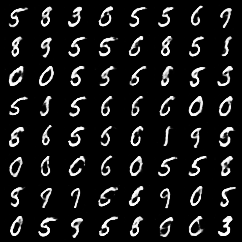

Epoch: 331  | 所要時間 0 分 6 秒
	Loss: -0.1345(Discriminator)
	Loss: -0.5336(Generator)
Epoch: 332  | 所要時間 0 分 6 秒
	Loss: -0.1480(Discriminator)
	Loss: -0.3691(Generator)
Epoch: 333  | 所要時間 0 分 5 秒
	Loss: -0.1444(Discriminator)
	Loss: -0.4839(Generator)
Epoch: 334  | 所要時間 0 分 6 秒
	Loss: -0.1347(Discriminator)
	Loss: -0.5087(Generator)
Epoch: 335  | 所要時間 0 分 6 秒
	Loss: -0.1329(Discriminator)
	Loss: -0.4629(Generator)


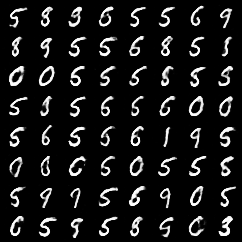

Epoch: 336  | 所要時間 0 分 6 秒
	Loss: -0.1338(Discriminator)
	Loss: -0.4830(Generator)
Epoch: 337  | 所要時間 0 分 6 秒
	Loss: -0.1463(Discriminator)
	Loss: -0.4290(Generator)
Epoch: 338  | 所要時間 0 分 6 秒
	Loss: -0.1337(Discriminator)
	Loss: -0.4425(Generator)
Epoch: 339  | 所要時間 0 分 6 秒
	Loss: -0.1424(Discriminator)
	Loss: -0.5403(Generator)
Epoch: 340  | 所要時間 0 分 6 秒
	Loss: -0.1524(Discriminator)
	Loss: -0.3957(Generator)


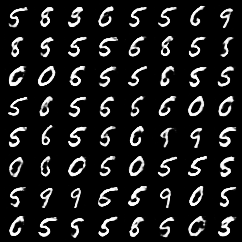

Epoch: 341  | 所要時間 0 分 6 秒
	Loss: -0.1431(Discriminator)
	Loss: -0.5580(Generator)
Epoch: 342  | 所要時間 0 分 6 秒
	Loss: -0.1422(Discriminator)
	Loss: -0.4516(Generator)
Epoch: 343  | 所要時間 0 分 6 秒
	Loss: -0.1447(Discriminator)
	Loss: -0.3650(Generator)
Epoch: 344  | 所要時間 0 分 6 秒
	Loss: -0.1410(Discriminator)
	Loss: -0.4408(Generator)
Epoch: 345  | 所要時間 0 分 6 秒
	Loss: -0.1388(Discriminator)
	Loss: -0.3563(Generator)


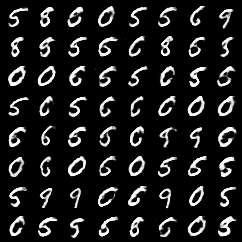

Epoch: 346  | 所要時間 0 分 6 秒
	Loss: -0.1284(Discriminator)
	Loss: -0.5463(Generator)
Epoch: 347  | 所要時間 0 分 6 秒
	Loss: -0.1302(Discriminator)
	Loss: -0.4106(Generator)
Epoch: 348  | 所要時間 0 分 6 秒
	Loss: -0.1535(Discriminator)
	Loss: -0.5362(Generator)
Epoch: 349  | 所要時間 0 分 6 秒
	Loss: -0.1368(Discriminator)
	Loss: -0.4041(Generator)
Epoch: 350  | 所要時間 0 分 6 秒
	Loss: -0.1327(Discriminator)
	Loss: -0.3526(Generator)


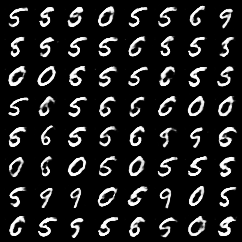

Epoch: 351  | 所要時間 0 分 6 秒
	Loss: -0.1430(Discriminator)
	Loss: -0.5294(Generator)
Epoch: 352  | 所要時間 0 分 6 秒
	Loss: -0.1429(Discriminator)
	Loss: -0.4754(Generator)
Epoch: 353  | 所要時間 0 分 6 秒
	Loss: -0.1365(Discriminator)
	Loss: -0.4834(Generator)
Epoch: 354  | 所要時間 0 分 6 秒
	Loss: -0.1289(Discriminator)
	Loss: -0.4790(Generator)
Epoch: 355  | 所要時間 0 分 6 秒
	Loss: -0.1409(Discriminator)
	Loss: -0.4065(Generator)


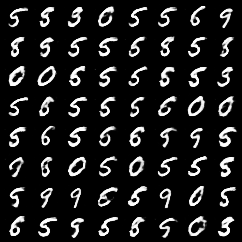

Epoch: 356  | 所要時間 0 分 6 秒
	Loss: -0.1308(Discriminator)
	Loss: -0.5239(Generator)
Epoch: 357  | 所要時間 0 分 6 秒
	Loss: -0.1413(Discriminator)
	Loss: -0.4830(Generator)
Epoch: 358  | 所要時間 0 分 6 秒
	Loss: -0.1371(Discriminator)
	Loss: -0.5045(Generator)
Epoch: 359  | 所要時間 0 分 6 秒
	Loss: -0.1402(Discriminator)
	Loss: -0.4569(Generator)
Epoch: 360  | 所要時間 0 分 6 秒
	Loss: -0.1312(Discriminator)
	Loss: -0.4409(Generator)


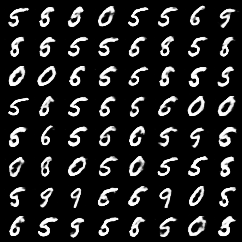

Epoch: 361  | 所要時間 0 分 6 秒
	Loss: -0.1445(Discriminator)
	Loss: -0.3858(Generator)
Epoch: 362  | 所要時間 0 分 6 秒
	Loss: -0.1418(Discriminator)
	Loss: -0.5603(Generator)
Epoch: 363  | 所要時間 0 分 6 秒
	Loss: -0.1327(Discriminator)
	Loss: -0.4021(Generator)
Epoch: 364  | 所要時間 0 分 6 秒
	Loss: -0.1350(Discriminator)
	Loss: -0.4979(Generator)
Epoch: 365  | 所要時間 0 分 6 秒
	Loss: -0.1329(Discriminator)
	Loss: -0.4945(Generator)


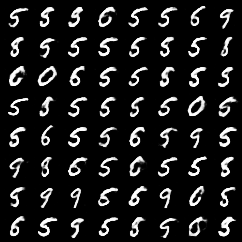

Epoch: 366  | 所要時間 0 分 6 秒
	Loss: -0.1335(Discriminator)
	Loss: -0.5283(Generator)
Epoch: 367  | 所要時間 0 分 6 秒
	Loss: -0.1287(Discriminator)
	Loss: -0.5645(Generator)
Epoch: 368  | 所要時間 0 分 6 秒
	Loss: -0.1353(Discriminator)
	Loss: -0.4755(Generator)
Epoch: 369  | 所要時間 0 分 6 秒
	Loss: -0.1300(Discriminator)
	Loss: -0.5213(Generator)
Epoch: 370  | 所要時間 0 分 6 秒
	Loss: -0.1400(Discriminator)
	Loss: -0.4842(Generator)


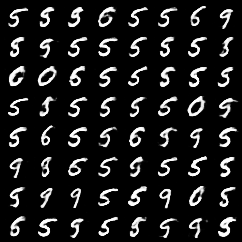

Epoch: 371  | 所要時間 0 分 6 秒
	Loss: -0.1381(Discriminator)
	Loss: -0.4474(Generator)
Epoch: 372  | 所要時間 0 分 6 秒
	Loss: -0.1383(Discriminator)
	Loss: -0.5208(Generator)
Epoch: 373  | 所要時間 0 分 6 秒
	Loss: -0.1371(Discriminator)
	Loss: -0.5532(Generator)
Epoch: 374  | 所要時間 0 分 6 秒
	Loss: -0.1289(Discriminator)
	Loss: -0.5465(Generator)
Epoch: 375  | 所要時間 0 分 5 秒
	Loss: -0.1424(Discriminator)
	Loss: -0.5472(Generator)


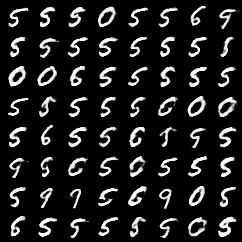

Epoch: 376  | 所要時間 0 分 6 秒
	Loss: -0.1300(Discriminator)
	Loss: -0.5893(Generator)
Epoch: 377  | 所要時間 0 分 6 秒
	Loss: -0.1256(Discriminator)
	Loss: -0.4704(Generator)
Epoch: 378  | 所要時間 0 分 6 秒
	Loss: -0.1369(Discriminator)
	Loss: -0.4833(Generator)
Epoch: 379  | 所要時間 0 分 6 秒
	Loss: -0.1321(Discriminator)
	Loss: -0.5189(Generator)
Epoch: 380  | 所要時間 0 分 6 秒
	Loss: -0.1328(Discriminator)
	Loss: -0.3847(Generator)


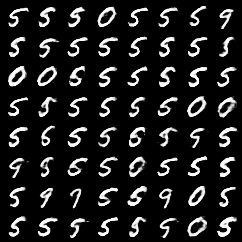

Epoch: 381  | 所要時間 0 分 6 秒
	Loss: -0.1419(Discriminator)
	Loss: -0.4343(Generator)
Epoch: 382  | 所要時間 0 分 6 秒
	Loss: -0.1393(Discriminator)
	Loss: -0.5002(Generator)
Epoch: 383  | 所要時間 0 分 6 秒
	Loss: -0.1316(Discriminator)
	Loss: -0.5203(Generator)
Epoch: 384  | 所要時間 0 分 6 秒
	Loss: -0.1325(Discriminator)
	Loss: -0.5550(Generator)
Epoch: 385  | 所要時間 0 分 6 秒
	Loss: -0.1376(Discriminator)
	Loss: -0.5624(Generator)


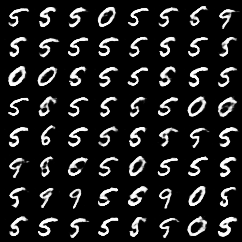

Epoch: 386  | 所要時間 0 分 6 秒
	Loss: -0.1278(Discriminator)
	Loss: -0.5467(Generator)
Epoch: 387  | 所要時間 0 分 6 秒
	Loss: -0.1357(Discriminator)
	Loss: -0.5614(Generator)
Epoch: 388  | 所要時間 0 分 6 秒
	Loss: -0.1370(Discriminator)
	Loss: -0.5065(Generator)
Epoch: 389  | 所要時間 0 分 6 秒
	Loss: -0.1289(Discriminator)
	Loss: -0.4937(Generator)
Epoch: 390  | 所要時間 0 分 6 秒
	Loss: -0.1332(Discriminator)
	Loss: -0.5676(Generator)


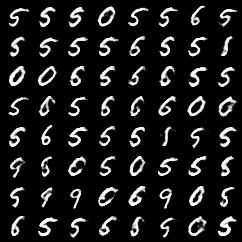

Epoch: 391  | 所要時間 0 分 6 秒
	Loss: -0.1316(Discriminator)
	Loss: -0.5821(Generator)
Epoch: 392  | 所要時間 0 分 6 秒
	Loss: -0.1446(Discriminator)
	Loss: -0.5305(Generator)
Epoch: 393  | 所要時間 0 分 6 秒
	Loss: -0.1401(Discriminator)
	Loss: -0.4492(Generator)
Epoch: 394  | 所要時間 0 分 6 秒
	Loss: -0.1480(Discriminator)
	Loss: -0.6492(Generator)
Epoch: 395  | 所要時間 0 分 6 秒
	Loss: -0.1343(Discriminator)
	Loss: -0.5693(Generator)


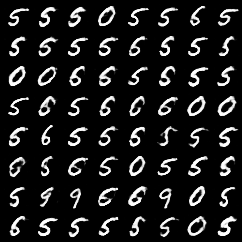

Epoch: 396  | 所要時間 0 分 6 秒
	Loss: -0.1373(Discriminator)
	Loss: -0.5312(Generator)
Epoch: 397  | 所要時間 0 分 6 秒
	Loss: -0.1253(Discriminator)
	Loss: -0.5296(Generator)
Epoch: 398  | 所要時間 0 分 6 秒
	Loss: -0.1394(Discriminator)
	Loss: -0.4398(Generator)
Epoch: 399  | 所要時間 0 分 6 秒
	Loss: -0.1386(Discriminator)
	Loss: -0.5094(Generator)
Epoch: 400  | 所要時間 0 分 6 秒
	Loss: -0.1314(Discriminator)
	Loss: -0.5217(Generator)


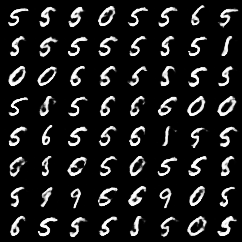

Epoch: 401  | 所要時間 0 分 6 秒
	Loss: -0.1342(Discriminator)
	Loss: -0.4472(Generator)
Epoch: 402  | 所要時間 0 分 6 秒
	Loss: -0.1333(Discriminator)
	Loss: -0.5485(Generator)
Epoch: 403  | 所要時間 0 分 6 秒
	Loss: -0.1294(Discriminator)
	Loss: -0.5016(Generator)
Epoch: 404  | 所要時間 0 分 6 秒
	Loss: -0.1308(Discriminator)
	Loss: -0.5282(Generator)
Epoch: 405  | 所要時間 0 分 6 秒
	Loss: -0.1249(Discriminator)
	Loss: -0.5112(Generator)


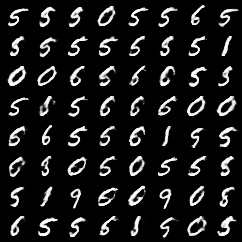

Epoch: 406  | 所要時間 0 分 6 秒
	Loss: -0.1354(Discriminator)
	Loss: -0.6402(Generator)
Epoch: 407  | 所要時間 0 分 6 秒
	Loss: -0.1247(Discriminator)
	Loss: -0.4955(Generator)
Epoch: 408  | 所要時間 0 分 6 秒
	Loss: -0.1288(Discriminator)
	Loss: -0.4419(Generator)
Epoch: 409  | 所要時間 0 分 6 秒
	Loss: -0.1389(Discriminator)
	Loss: -0.5221(Generator)
Epoch: 410  | 所要時間 0 分 6 秒
	Loss: -0.1337(Discriminator)
	Loss: -0.5203(Generator)


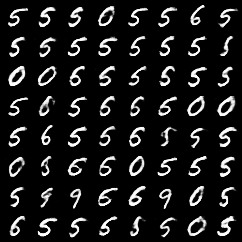

Epoch: 411  | 所要時間 0 分 6 秒
	Loss: -0.1440(Discriminator)
	Loss: -0.5868(Generator)
Epoch: 412  | 所要時間 0 分 6 秒
	Loss: -0.1277(Discriminator)
	Loss: -0.5749(Generator)
Epoch: 413  | 所要時間 0 分 6 秒
	Loss: -0.1282(Discriminator)
	Loss: -0.5446(Generator)
Epoch: 414  | 所要時間 0 分 6 秒
	Loss: -0.1325(Discriminator)
	Loss: -0.5773(Generator)
Epoch: 415  | 所要時間 0 分 6 秒
	Loss: -0.1367(Discriminator)
	Loss: -0.5322(Generator)


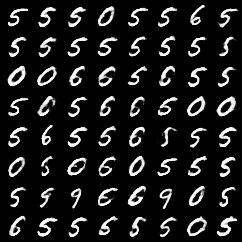

Epoch: 416  | 所要時間 0 分 6 秒
	Loss: -0.1266(Discriminator)
	Loss: -0.6251(Generator)
Epoch: 417  | 所要時間 0 分 6 秒
	Loss: -0.1330(Discriminator)
	Loss: -0.5426(Generator)
Epoch: 418  | 所要時間 0 分 6 秒
	Loss: -0.1319(Discriminator)
	Loss: -0.5996(Generator)
Epoch: 419  | 所要時間 0 分 6 秒
	Loss: -0.1348(Discriminator)
	Loss: -0.4438(Generator)
Epoch: 420  | 所要時間 0 分 6 秒
	Loss: -0.1342(Discriminator)
	Loss: -0.6641(Generator)


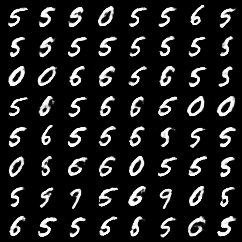

Epoch: 421  | 所要時間 0 分 6 秒
	Loss: -0.1433(Discriminator)
	Loss: -0.4878(Generator)
Epoch: 422  | 所要時間 0 分 6 秒
	Loss: -0.1258(Discriminator)
	Loss: -0.5068(Generator)
Epoch: 423  | 所要時間 0 分 6 秒
	Loss: -0.1346(Discriminator)
	Loss: -0.6374(Generator)
Epoch: 424  | 所要時間 0 分 6 秒
	Loss: -0.1387(Discriminator)
	Loss: -0.5551(Generator)
Epoch: 425  | 所要時間 0 分 6 秒
	Loss: -0.1381(Discriminator)
	Loss: -0.6187(Generator)


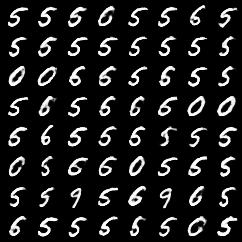

Epoch: 426  | 所要時間 0 分 6 秒
	Loss: -0.1262(Discriminator)
	Loss: -0.5731(Generator)
Epoch: 427  | 所要時間 0 分 6 秒
	Loss: -0.1253(Discriminator)
	Loss: -0.5965(Generator)
Epoch: 428  | 所要時間 0 分 6 秒
	Loss: -0.1357(Discriminator)
	Loss: -0.5614(Generator)
Epoch: 429  | 所要時間 0 分 6 秒
	Loss: -0.1301(Discriminator)
	Loss: -0.5538(Generator)
Epoch: 430  | 所要時間 0 分 6 秒
	Loss: -0.1372(Discriminator)
	Loss: -0.5119(Generator)


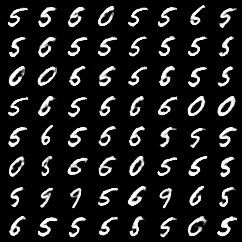

Epoch: 431  | 所要時間 0 分 6 秒
	Loss: -0.1356(Discriminator)
	Loss: -0.5452(Generator)
Epoch: 432  | 所要時間 0 分 6 秒
	Loss: -0.1231(Discriminator)
	Loss: -0.5152(Generator)
Epoch: 433  | 所要時間 0 分 6 秒
	Loss: -0.1343(Discriminator)
	Loss: -0.5027(Generator)
Epoch: 434  | 所要時間 0 分 6 秒
	Loss: -0.1433(Discriminator)
	Loss: -0.5032(Generator)
Epoch: 435  | 所要時間 0 分 6 秒
	Loss: -0.1314(Discriminator)
	Loss: -0.5488(Generator)


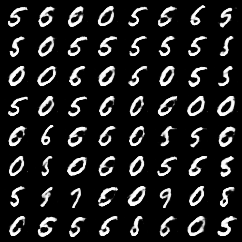

Epoch: 436  | 所要時間 0 分 6 秒
	Loss: -0.1316(Discriminator)
	Loss: -0.5318(Generator)
Epoch: 437  | 所要時間 0 分 6 秒
	Loss: -0.1406(Discriminator)
	Loss: -0.6582(Generator)
Epoch: 438  | 所要時間 0 分 6 秒
	Loss: -0.1361(Discriminator)
	Loss: -0.4230(Generator)
Epoch: 439  | 所要時間 0 分 6 秒
	Loss: -0.1335(Discriminator)
	Loss: -0.7142(Generator)
Epoch: 440  | 所要時間 0 分 6 秒
	Loss: -0.1327(Discriminator)
	Loss: -0.5559(Generator)


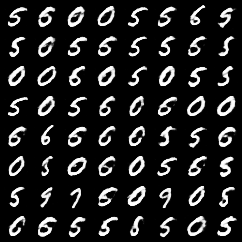

Epoch: 441  | 所要時間 0 分 6 秒
	Loss: -0.1307(Discriminator)
	Loss: -0.5798(Generator)
Epoch: 442  | 所要時間 0 分 6 秒
	Loss: -0.1354(Discriminator)
	Loss: -0.5953(Generator)
Epoch: 443  | 所要時間 0 分 6 秒
	Loss: -0.1244(Discriminator)
	Loss: -0.5618(Generator)
Epoch: 444  | 所要時間 0 分 6 秒
	Loss: -0.1333(Discriminator)
	Loss: -0.6327(Generator)
Epoch: 445  | 所要時間 0 分 6 秒
	Loss: -0.1220(Discriminator)
	Loss: -0.6048(Generator)


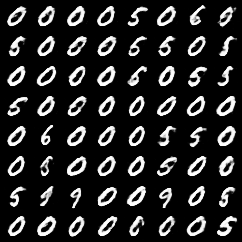

Epoch: 446  | 所要時間 0 分 6 秒
	Loss: -0.1326(Discriminator)
	Loss: -0.4419(Generator)
Epoch: 447  | 所要時間 0 分 6 秒
	Loss: -0.1330(Discriminator)
	Loss: -0.6894(Generator)
Epoch: 448  | 所要時間 0 分 6 秒
	Loss: -0.1418(Discriminator)
	Loss: -0.5362(Generator)
Epoch: 449  | 所要時間 0 分 6 秒
	Loss: -0.1382(Discriminator)
	Loss: -0.4635(Generator)
Epoch: 450  | 所要時間 0 分 6 秒
	Loss: -0.1345(Discriminator)
	Loss: -0.5543(Generator)


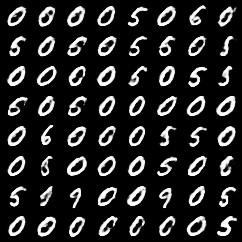

Epoch: 451  | 所要時間 0 分 6 秒
	Loss: -0.1326(Discriminator)
	Loss: -0.5476(Generator)
Epoch: 452  | 所要時間 0 分 6 秒
	Loss: -0.1356(Discriminator)
	Loss: -0.5717(Generator)
Epoch: 453  | 所要時間 0 分 6 秒
	Loss: -0.1269(Discriminator)
	Loss: -0.5964(Generator)
Epoch: 454  | 所要時間 0 分 6 秒
	Loss: -0.1411(Discriminator)
	Loss: -0.5549(Generator)
Epoch: 455  | 所要時間 0 分 6 秒
	Loss: -0.1260(Discriminator)
	Loss: -0.5572(Generator)


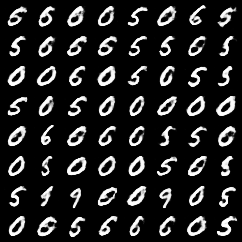

Epoch: 456  | 所要時間 0 分 6 秒
	Loss: -0.1310(Discriminator)
	Loss: -0.5158(Generator)
Epoch: 457  | 所要時間 0 分 6 秒
	Loss: -0.1250(Discriminator)
	Loss: -0.5865(Generator)
Epoch: 458  | 所要時間 0 分 6 秒
	Loss: -0.1258(Discriminator)
	Loss: -0.5749(Generator)
Epoch: 459  | 所要時間 0 分 6 秒
	Loss: -0.1366(Discriminator)
	Loss: -0.6326(Generator)
Epoch: 460  | 所要時間 0 分 6 秒
	Loss: -0.1343(Discriminator)
	Loss: -0.5787(Generator)


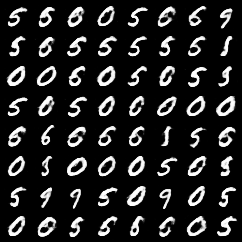

Epoch: 461  | 所要時間 0 分 6 秒
	Loss: -0.1297(Discriminator)
	Loss: -0.5609(Generator)
Epoch: 462  | 所要時間 0 分 6 秒
	Loss: -0.1287(Discriminator)
	Loss: -0.5281(Generator)
Epoch: 463  | 所要時間 0 分 6 秒
	Loss: -0.1258(Discriminator)
	Loss: -0.5686(Generator)
Epoch: 464  | 所要時間 0 分 6 秒
	Loss: -0.1218(Discriminator)
	Loss: -0.4583(Generator)
Epoch: 465  | 所要時間 0 分 6 秒
	Loss: -0.1300(Discriminator)
	Loss: -0.6839(Generator)


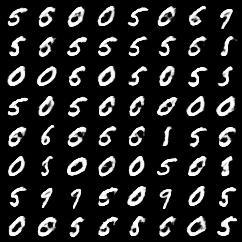

Epoch: 466  | 所要時間 0 分 6 秒
	Loss: -0.1395(Discriminator)
	Loss: -0.4036(Generator)
Epoch: 467  | 所要時間 0 分 6 秒
	Loss: -0.1271(Discriminator)
	Loss: -0.6896(Generator)
Epoch: 468  | 所要時間 0 分 6 秒
	Loss: -0.1366(Discriminator)
	Loss: -0.5236(Generator)
Epoch: 469  | 所要時間 0 分 6 秒
	Loss: -0.1303(Discriminator)
	Loss: -0.6179(Generator)
Epoch: 470  | 所要時間 0 分 6 秒
	Loss: -0.1275(Discriminator)
	Loss: -0.5983(Generator)


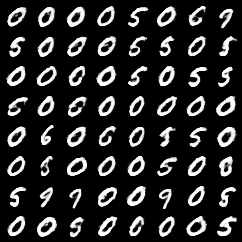

Epoch: 471  | 所要時間 0 分 6 秒
	Loss: -0.1240(Discriminator)
	Loss: -0.6025(Generator)
Epoch: 472  | 所要時間 0 分 6 秒
	Loss: -0.1331(Discriminator)
	Loss: -0.5427(Generator)
Epoch: 473  | 所要時間 0 分 6 秒
	Loss: -0.1344(Discriminator)
	Loss: -0.7367(Generator)
Epoch: 474  | 所要時間 0 分 6 秒
	Loss: -0.1284(Discriminator)
	Loss: -0.5562(Generator)
Epoch: 475  | 所要時間 0 分 6 秒
	Loss: -0.1295(Discriminator)
	Loss: -0.5612(Generator)


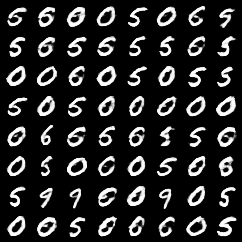

Epoch: 476  | 所要時間 0 分 6 秒
	Loss: -0.1256(Discriminator)
	Loss: -0.6389(Generator)
Epoch: 477  | 所要時間 0 分 6 秒
	Loss: -0.1268(Discriminator)
	Loss: -0.5755(Generator)
Epoch: 478  | 所要時間 0 分 6 秒
	Loss: -0.1248(Discriminator)
	Loss: -0.5532(Generator)
Epoch: 479  | 所要時間 0 分 6 秒
	Loss: -0.1315(Discriminator)
	Loss: -0.5445(Generator)
Epoch: 480  | 所要時間 0 分 6 秒
	Loss: -0.1316(Discriminator)
	Loss: -0.5998(Generator)


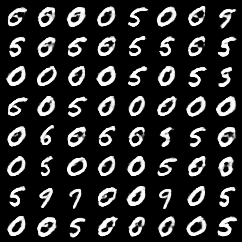

Epoch: 481  | 所要時間 0 分 6 秒
	Loss: -0.1306(Discriminator)
	Loss: -0.4560(Generator)
Epoch: 482  | 所要時間 0 分 6 秒
	Loss: -0.1220(Discriminator)
	Loss: -0.5779(Generator)
Epoch: 483  | 所要時間 0 分 6 秒
	Loss: -0.1296(Discriminator)
	Loss: -0.6273(Generator)
Epoch: 484  | 所要時間 0 分 6 秒
	Loss: -0.1314(Discriminator)
	Loss: -0.6274(Generator)
Epoch: 485  | 所要時間 0 分 6 秒
	Loss: -0.1313(Discriminator)
	Loss: -0.6184(Generator)


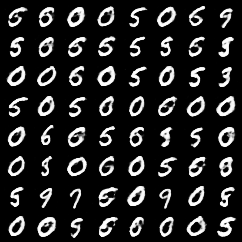

Epoch: 486  | 所要時間 0 分 6 秒
	Loss: -0.1262(Discriminator)
	Loss: -0.6992(Generator)
Epoch: 487  | 所要時間 0 分 6 秒
	Loss: -0.1299(Discriminator)
	Loss: -0.5623(Generator)
Epoch: 488  | 所要時間 0 分 6 秒
	Loss: -0.1290(Discriminator)
	Loss: -0.5746(Generator)
Epoch: 489  | 所要時間 0 分 6 秒
	Loss: -0.1203(Discriminator)
	Loss: -0.5269(Generator)
Epoch: 490  | 所要時間 0 分 6 秒
	Loss: -0.1319(Discriminator)
	Loss: -0.5726(Generator)


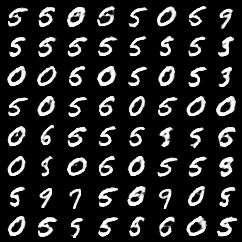

Epoch: 491  | 所要時間 0 分 6 秒
	Loss: -0.1264(Discriminator)
	Loss: -0.5266(Generator)
Epoch: 492  | 所要時間 0 分 6 秒
	Loss: -0.1279(Discriminator)
	Loss: -0.6584(Generator)
Epoch: 493  | 所要時間 0 分 6 秒
	Loss: -0.1228(Discriminator)
	Loss: -0.6135(Generator)
Epoch: 494  | 所要時間 0 分 6 秒
	Loss: -0.1282(Discriminator)
	Loss: -0.6624(Generator)
Epoch: 495  | 所要時間 0 分 6 秒
	Loss: -0.1297(Discriminator)
	Loss: -0.5473(Generator)


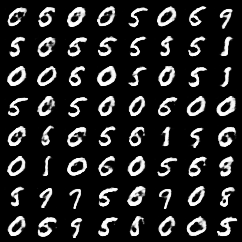

Epoch: 496  | 所要時間 0 分 6 秒
	Loss: -0.1300(Discriminator)
	Loss: -0.6236(Generator)
Epoch: 497  | 所要時間 0 分 6 秒
	Loss: -0.1227(Discriminator)
	Loss: -0.6096(Generator)
Epoch: 498  | 所要時間 0 分 6 秒
	Loss: -0.1270(Discriminator)
	Loss: -0.6787(Generator)
Epoch: 499  | 所要時間 0 分 6 秒
	Loss: -0.1238(Discriminator)
	Loss: -0.7059(Generator)
Epoch: 500  | 所要時間 0 分 6 秒
	Loss: -0.1278(Discriminator)
	Loss: -0.6289(Generator)


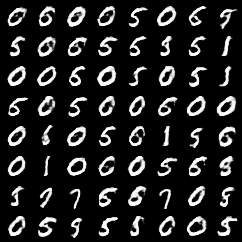

In [19]:
D_loss_list, G_loss_list = model_run(num_epochs = 500, D_optim = 'Adam', G_optim = 'Adam')

## グラフにGeneratorとDiscriminatorのlossを表示する関数

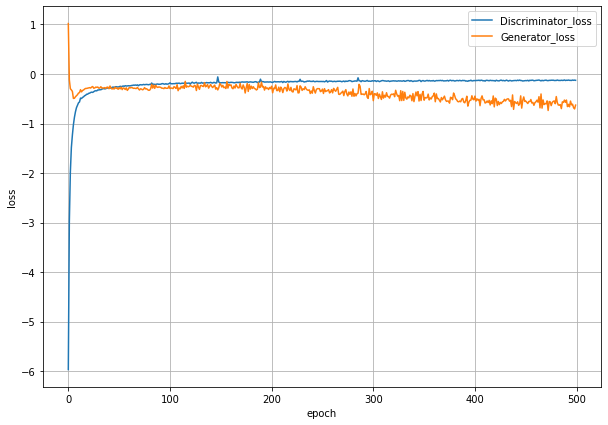

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))

loss = fig.add_subplot(1,1,1)

loss.plot(range(len(D_loss_list)),D_loss_list,label='Discriminator_loss')
loss.plot(range(len(G_loss_list)),G_loss_list,label='Generator_loss')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')

loss.legend()
loss.grid()

fig.show()

## Animation GIFを作る

In [14]:
import glob
from PIL import Image

files = glob.glob('./logs_WGAN/*.png')
files.sort()

images = list(map(lambda file: Image.open(file), files))

images[0].save('WGAN.gif', save_all=True, append_images=images[1:], duration=100, loop=0)